# EXEMPLO 2 - Rede Neural. Estudo de Caso: Mnist.

Neste exemplo, vamos utilizar uma Rede Neural para resolver um problema clássico de classificação: o reconhecimento de dígitos escritos à mão, utilizando o dataset MNIST.

O MNIST é um conjunto de dados muito conhecido na área de Machine Learning.
Ele contém milhares de imagens em preto e branco de dígitos de 0 a 9, escritas à mão,
e o objetivo é treinar um modelo que consiga identificar corretamente qual número aparece em cada imagem.

Vamos usar uma Rede Neural simples (usando PyTorch) para aprender os padrões dessas imagens
e, depois do treinamento, testar sua capacidade de reconhecer novos dígitos.

Esse exemplo é muito útil para entender como redes neurais funcionam em problemas visuais
e serve como porta de entrada para tarefas mais complexas de Visão Computacional.

In [32]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

## Carregando e preparando o dataset MNIST.

Primeiro, usamos *transforms.ToTensor()* para converter as imagens para tensores do PyTorch
e normalizar os valores dos pixels (de 0–255 para 0–1).

Em seguida, carregamos o dataset MNIST com datasets.MNIST(), indicando o caminho onde os dados ficarão salvos.
O parâmetro download=True baixa os dados se ainda não existirem no diretório.
**Atenção**: train=False indica que estamos pegando o conjunto de TESTE — use train=True se quiser o conjunto de treino.

Depois, usamos DataLoader para organizar os dados em batches (lotes) de 64 imagens e embaralhá-los a cada época.
Isso é importante para acelerar e estabilizar o treinamento da rede neural.

In [33]:
transform = transforms.ToTensor();

trainset = datasets.MNIST('C:\\Users\\Matheus\\Documents\\Github Projects\\research_MLs\\material_estudo\\hands_on\\datasets\\mnist',download=True,train=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)

valset = datasets.MNIST('C:\\Users\\Matheus\\Documents\\Github Projects\\research_MLs\\material_estudo\\hands_on\\datasets\\mnist',download=True,train=False,transform=transform)
valloader = torch.utils.data.DataLoader(valset,batch_size=64,shuffle=True)

Vamos visualizar uma imagem real do dataset MNIST.

Primeiro, usamos iter(trainloader) para criar um iterador sobre o DataLoader,
e usamos next() para pegar o primeiro lote de imagens e etiquetas.

Depois, selecionamos a primeira imagem do lote (imagens[0]),
convertemos para NumPy com .numpy() e removemos dimensões extras com .squeeze().

Por fim, mostramos a imagem usando plt.imshow() com a coloração em tons de cinza.
Isso nos permite visualizar os dígitos reais que o modelo vai aprender a reconhecer.


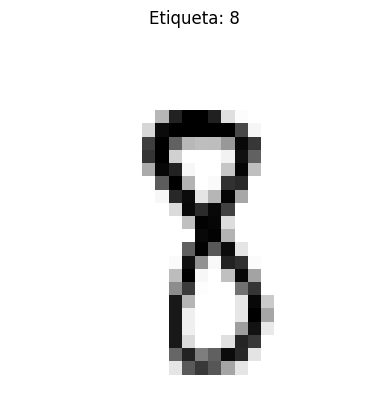

In [34]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)

plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')
plt.title(f"Etiqueta: {etiquetas[0].item()}")
plt.axis('off')  # opcional: tira os eixos
plt.show()


Vamos inspecionar as dimensões (shape) da imagem e da etiqueta.

A imagem (imagens[0]) tem shape [1, 28, 28], onde:
- 1 representa o canal da imagem (escala de cinza),
- 28x28 é a resolução da imagem em pixels.

Já a etiqueta (etiquetas[0]) é um valor escalar, como 0, 1, 2, ..., 9,
que representa qual número está escrito na imagem. Por isso, ela não tem shape — é só um número.

### Por que isso é importante?
Verificar o shape dos dados nos ajuda a entender como a rede neural irá recebê-los.
Se a dimensão dos dados estiver errada, isso pode causar erros no treinamento,
como incompatibilidades entre camadas ou falhas na visualização.

Essa etapa também ajuda a desenvolver a intuição sobre como os dados estão organizados internamente
e é essencial para evitar bugs difíceis de detectar mais à frente no projeto.


In [35]:
print(imagens[0].shape)
print(etiquetas[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


### COMPARAÇÃO ENTRE DUAS ARQUITETURAS DE REDES NEURAIS

CODE 1 - Arquitetura com 3 camadas lineares (mais profunda)
Neste modelo, passamos a imagem por duas camadas ocultas com ReLU,
depois aplicamos uma camada final com log_softmax para gerar probabilidades normalizadas.
Essa saída é ideal para ser usada com a função de perda NLLLoss.

CODE 2 - Arquitetura com 2 camadas lineares (mais simples)
O modelo achata a imagem no início e passa por uma camada oculta seguida de ReLU,
e depois uma saída com 10 neurônios. Essa versão entrega logits brutos,
então deve ser usada com a função CrossEntropyLoss (que aplica o softmax internamente).

A escolha entre modelos mais simples ou mais profundos depende da tarefa, tempo de treino
e capacidade computacional. Modelos mais profundos geralmente aprendem padrões mais complexos,
mas podem levar mais tempo para treinar e exigir regularização.

In [41]:
# CODE 1 - Escolha um modelo antes de executar
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo,self).__init__()
        self.linear1 = nn.Linear(28*28,128)
        self.linear2 = nn.Linear(128,64)
        self.linear3 = nn.Linear(64,10)

    def forward(self, X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return f.log_softmax(X,dim=1)

In [37]:
# CODE 2 - Escolha um modelo antes de executar
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 128)   # Camada oculta com 128 neurônios
        self.linear2 = nn.Linear(128, 10)        # Camada de saída com 10 neurônios (0 a 9)

    def forward(self, x):
        x = x.view(x.shape[0], -1)               # Achata a imagem de [1, 28, 28] para [784]
        x = F.relu(self.linear1(x))              # Aplica ReLU na primeira camada
        x = self.linear2(x)                      # Saída da rede (logits)
        return x

In [42]:
def treino(modelo,trainloader,device):
    otimizador = optim.SGD(modelo.parameters(),lr=0.01,momentum=0.5)
    inicio = time()

    criterio = nn.NLLLoss()
    EPOCDS = 10
    modelo.train()

    for epoch in range(EPOCHS):
        perda_acumulada = 0
        for imagens, etiquetas in trainloader:
            imagens = imagens.view(imagens.shape[0],-1)
            otimizador.zero_grad()

            output = modelo(imagens.to(device))
            perda_instantanea = criterio(output, etiquetas.to(device))

            perda_instantanea.backward()

            otimizador.step()

            perda_acumulada += perda_instantanea.item()

        else:
            print("Epoch {} - Perda Resultante: {}".format(epoch+1,perda_acumulada/len(trainloader)))
    print("\nTempo de treinamento (Min):",(time()-inicio)/60)
            

In [43]:
def validacao(modelo,valloader,device):
    conta_corretas,conta_todas = 0,0
    for imagens,etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1,784)
            with torch.no_grad():
                logps = modelo(img.to(device))

            ps = torch.exp(logps)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab))
            etiqueta_certa = etiquetas.numpy()[i]
            if(etiqueta_certa == etiqueta_pred):
                conta_corretas += 1
            conta_todas += 1

        print("Total de imagens testadas: ", conta_todas)
        print("\nPrecisão do modelo: {}%",format(conta_corretas*100/conta_todas))

In [44]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)